In [1]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from utils.utils_figures import tendency_to_col_dict, structure_to_col_dict, organism_to_col_dict, technique_to_col_dict, keyword_to_col_dict, algo_to_col_dict, year_to_col_dict

In [2]:
#metric, metricnameinunivariate = 'f1_score', 'f1_avg'
#metric, metricnameinunivariate = 'accuracy', 'accuracy_avg'
metric, metricnameinunivariate = 'balancedaccuracy', 'balancedaccuracy_avg'
#metric, metricnameinunivariate = 'mcc', 'mccscore_avg'

# import meta df
meta_df = pd.read_csv(f'meta_df_{metric}.csv', index_col=0)
meta_df = meta_df[meta_df['tendency'] != '?']
meta_df = meta_df.rename(columns={'embeddings_PC0': 'PC0', 'embeddings_PC1': 'PC1'})


In [3]:
def def_figure_variables(meta_df, coloring_method):
    if coloring_method == 'tendency':
        column_to_color = 'tendency'
        title_coloring = "colored by: tendency"
        color_dict = tendency_to_col_dict
    elif coloring_method == 'linear or rule-based':
        column_to_color = 'structure of best method'
        title_coloring = "colored by: linear or rule-based tendency"
        color_dict = structure_to_col_dict
    elif coloring_method == 'organism':
        column_to_color = 'organism curated'
        title_coloring = "colored by: organism"
        color_dict = organism_to_col_dict
    elif coloring_method == 'is fat':
        column_to_color = 'is fat'
        title_coloring = "colored by: is fat"
        color_dict = None
    elif coloring_method == 'metabolomics technique':
        # tehcnique with more than 1 occurence
        common_techniques = meta_df['technique category'].value_counts()[meta_df['technique category'].value_counts() > 1].index
        meta_df['technique category'] = meta_df['technique category'].apply(lambda x: x if x in common_techniques else 'other')
        # replace '?' with 'other'
        meta_df['technique category'] = meta_df['technique category'].apply(lambda x: 'other' if x == '?' else x)
        column_to_color = 'technique category'
        title_coloring = "colored by: metabolomics technique"
        color_dict = technique_to_col_dict
    elif coloring_method == 'affiliation':
        common_affiliations = meta_df['affiliation'].value_counts()[meta_df['affiliation'].value_counts() > 8].index
        meta_df['affiliation'] = meta_df['affiliation'].apply(lambda x: x if x in common_affiliations else 'other')
        # merge 'other' and 'unknown'
        meta_df['affiliation'] = meta_df['affiliation'].apply(lambda x: 'other or unknown' if x in ['unknown', 'other'] else x)
        short_affiliations = []
        for aff in meta_df['affiliation']:
            if len(aff) > 80:
                short_affiliations.append(','.join([aff.split(',')[0], aff.split(',')[-2], aff.split(',')[-1]]))
            else:
                short_affiliations.append(aff)
        meta_df['affiliation'] = short_affiliations
        column_to_color = 'affiliation'
        title_coloring = "colored by: affiliation"
        color_dict = {}
        print(len(set(meta_df['affiliation'])))
        colors = px.colors.qualitative.Plotly + list(plt.cm.tab10.colors)
        unique_affiliations = list(set(meta_df['affiliation']))
        for a in unique_affiliations:
            color_dict[a] = colors[unique_affiliations.index(a)]
        color_dict['other or unknown'] = '#cccccc'
    elif coloring_method == 'phenotype_keyword':
        column_to_color = 'phenotype keyword'
        title_coloring = "colored by: phenotype keyword"
        color_dict = keyword_to_col_dict
    return meta_df, column_to_color, title_coloring, color_dict

number of datasets: 832
phenotype_keyword
phenotype keyword
other : 361 (43%)
treatment : 138 (17%)
disease : 133 (16%)
mutation : 64 (8%)
cultivar : 33 (4%)
diet : 31 (4%)
cancer : 30 (4%)
location : 20 (2%)
age : 11 (1%)
birth : 11 (1%)
organism
organism curated
Homo sapiens : 305 (37%)
Plants : 156 (19%)
other or unknown : 132 (16%)
other mammals : 68 (8%)
Bacteria : 66 (8%)
Mus musculus : 58 (7%)
multiple : 47 (6%)
metabolomics technique
technique category
LCMS : 568 (68%)
GCMS : 124 (15%)
other : 74 (9%)
NMR : 48 (6%)
DIMS : 18 (2%)


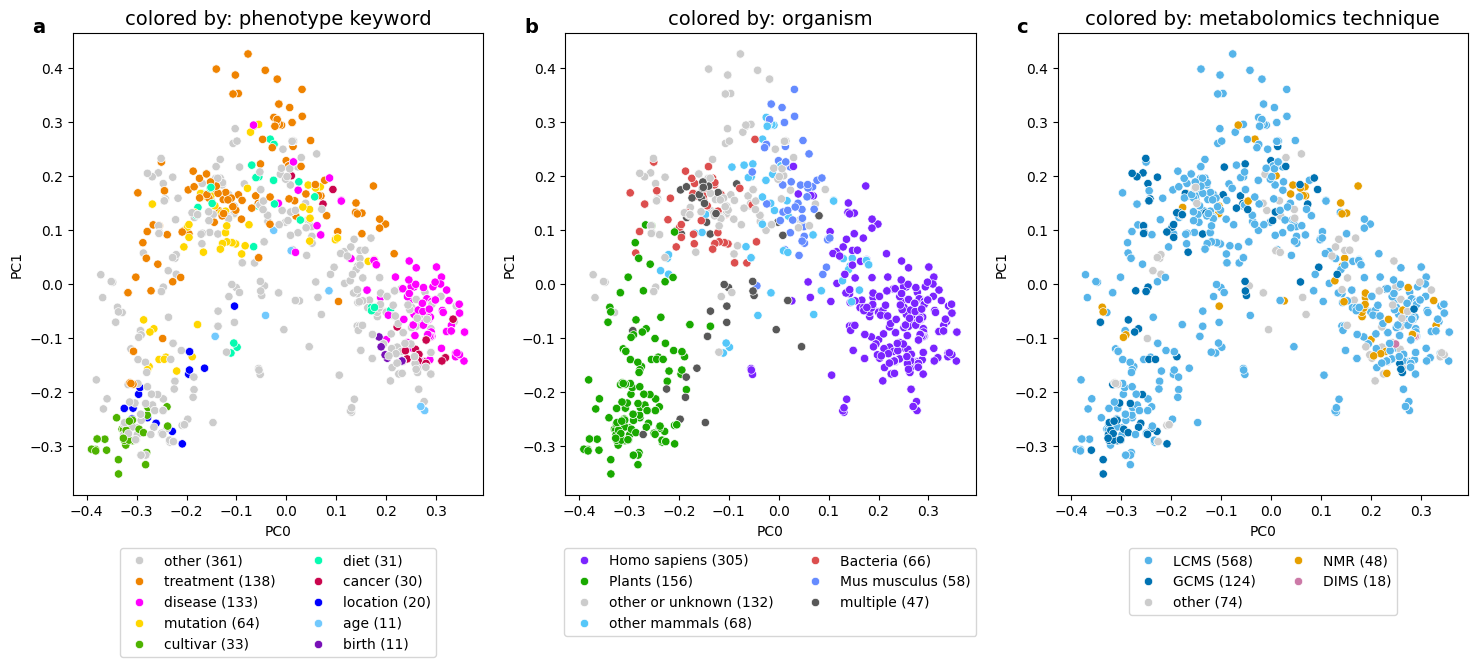

In [4]:
# big figure with 6 plots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
i=0
print('number of datasets:', len(meta_df))
for coloring_method in ['phenotype_keyword', 'organism', 'metabolomics technique']:
#for coloring_method in ['metabolomics technique']:
    meta_df, column_to_color, title_coloring, color_dict = def_figure_variables(meta_df, coloring_method)
    print(coloring_method)
    print(column_to_color)
    #print(meta_df[column_to_color].value_counts())
    for k, v in meta_df[column_to_color].value_counts().items():
        print(f'{k} : {v} ({v/len(meta_df)*100:.0f}%)')
    if '?' in meta_df[column_to_color].value_counts().index:
        raise ValueError(f"value '?' found in {column_to_color}")
    # rename the columns dim0 and dim1
    sns.scatterplot(data=meta_df, x='PC0', y='PC1', hue=column_to_color, palette=color_dict, ax=axs[i])
    axs[i].set_title(title_coloring, fontsize=14)
    # legend on the top of the plot
    # sort the legend
    handles, labels = axs[i].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    # sort by occurence in the dataframe
    by_label = dict(sorted(by_label.items(), key=lambda item: meta_df[column_to_color].value_counts().index.tolist().index(item[0])))
    # add the number of occurence in () in the keys of the dict
    by_label = {f"{k} ({meta_df[column_to_color].value_counts()[k]})": v for k, v in by_label.items()}
    axs[i].legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
    axs[i].text(-0.1, 1.0, 'abc'[i], transform=axs[i].transAxes, size=14, weight='bold')
    i += 1
plt.savefig('figures/figure0_data_description.pdf', bbox_inches='tight')


In [5]:
# average and median values of n samples
print('The average number of samples per dataset is:', meta_df['n samples'].mean(), 'while the median is:', meta_df['n samples'].median())
# same for n features
print('The average number of features per dataset is:', meta_df['n features'].mean(), 'while the median is:', meta_df['n features'].median())
# same for the ratio
print('The average ratio of features to samples per dataset is:', meta_df['fatness'].mean(), 'while the median is:', meta_df['fatness'].median())

The average number of samples per dataset is: 163.65745192307693 while the median is: 61.0
The average number of features per dataset is: 759.6514423076923 while the median is: 135.0
The average ratio of features to samples per dataset is: 13.939976150930262 while the median is: 2.2434210526315788
